# Sparkify Initial Data Exploration
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [117]:
# import packages
import os
import re
import sys
print("start SPARK application")

start SPARK application


In [118]:
# this cell is used on AWS EMR
# os.environ["SPARK_HOME"] = "/usr/lib/spark/"
# os.environ["PYSPARK_PYTHON"] = "/mnt/anaconda3/bin/python3.7"
# spark_home = os.environ.get('SPARK_HOME', None)
# sys.path.insert(0, spark_home + "/python")
# sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-src.zip'))

# from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("yarn").getOrCreate()
# spark.conf.set("spark.sql.broadcastTimeout", 72000)

In [119]:
# import libraries
import os
import re
import copy
import time
import datetime
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

%matplotlib inline

In [120]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [121]:
def cleanse_data(df):
    """
    Removes special characters from StringType columns 
    (special chars. except , and - which might be useful for splitting columns)
    Casts miliseconds ts column and creates two new columns with timestamptype and datetype,
    which will be used for further processing
    Extracts month from ts
    Casts user id to LongType
    Splits location field and takes only state name as location
    :param df: Spark DataFrame
    :return df preprocessed Spark DataFrame
    """
    # cleanse stringtype fields from special characters
    for field in df.schema.fields:
        if field.dataType==StringType():
            df = df.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))
    
    df = df.withColumn('interaction_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    df = df.withColumn('month', month(col('interaction_time')))
    df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
    df = df.withColumn('userId', col('userId').cast(LongType()))
    df = df.filter(col('userId').isNotNull())
    df = df.filter(col('auth')!='LoggedOut')
    df = df.withColumn('location', split(col('location'),',').getItem(1))
    
    return df
    

In [122]:
def label_data(df):
    """
    Calculates features from existing fields
    Adds label column
    :param df: spark DataFrame
    """
   
    label_df = df.withColumn('label',
                             when((col('page').\
                                   isin(['Cancellation Confirmation','Cancel'])) | \
                                  (col('auth')=='Cancelled'),1 ).\
                             otherwise(0)).\
    groupby('userId').agg(sum('label').alias('label')).\
    withColumn('label', when(col('label')>=1 ,1).otherwise(0))

    df = df.join(label_df, on='userId')

    return df

In [123]:
def registered_days(df):
    """
    Calculates number of days between registration to last interaction
    :param df: spark DataFrame
    :return df with calculated column
    """
    last_interaction_df =  df.groupBy('userId').agg(max('ts').alias('last_interaction'))

    df = last_interaction_df.join(df, on='userId').withColumn('registered_days', ((col('last_interaction')-col('registration'))/86400000).cast(IntegerType()))
    return df

In [124]:
# please comment out to create a Spark session
# spark = SparkSession \
#     .builder \
#     .appName("Sparkify") \
#     .getOrCreate()

# Read in full sparkify dataset
event_data = "medium-sparkify-event-data.json"

In [125]:
df = spark.read.json(file_path)

In [126]:
df.count()

543705

In [127]:
pd.DataFrame(df.take(5), columns=df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,246


In [128]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Some fields can be integer instead of string(such as userId), cleansing special characters might help to find right schema for fields.

**Number of distinct users:**

In [129]:
df.select('userId').distinct().count()

449

**Logs Time frame:**

In [130]:
df.agg(max(from_unixtime(col('ts')/1000).cast(DateType())),min(from_unixtime(col('ts')/1000).cast(DateType()))).collect()

[Row(max(CAST(from_unixtime((ts / 1000), yyyy-MM-dd HH:mm:ss) AS DATE))=datetime.date(2018, 12, 1), min(CAST(from_unixtime((ts / 1000), yyyy-MM-dd HH:mm:ss) AS DATE))=datetime.date(2018, 10, 1))]

So We have 2 months of data.

**Distinct Values for Columns of Interest**

In [131]:
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [132]:
df.select('auth').distinct().collect()

[Row(auth='Logged Out'),
 Row(auth='Cancelled'),
 Row(auth='Guest'),
 Row(auth='Logged In')]

In [133]:
df.select('level').distinct().collect()

[Row(level='free'), Row(level='paid')]

In [134]:
df.select('gender').distinct().collect()

[Row(gender='F'), Row(gender=None), Row(gender='M')]

In [135]:
df.select('status').distinct().collect()

[Row(status=307), Row(status=404), Row(status=200)]

In [136]:
df.select('method').distinct().collect()

[Row(method='PUT'), Row(method='GET')]

**Null check**

In [137]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



**It is obvious that there is a pattern in the nulls**

In [138]:
df.where("artist is null").show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In| Maverick|     M|          185|Santiago|  null| paid|Orlando-Kissimmee...|   PUT|         Logout|1535953455000|      178|null|   307|1538352119000|"Mozilla/5.0 (Mac...|   179|
|  null|Logged Out|     null|  null|          186|    null|  null| paid|                null|   GET|           Home|         null|      178|null|   200|1538352148000|                null|      |
|  null|Logged Out|     n

In [139]:
set(df.select('page').distinct().collect())-set(df.where("artist is null").select('page').distinct().collect())
    
    

{Row(page='NextSong')}

**We can see that artist,length and song are null whenever auth is LoggedOut or page is different than NextSong.**

In [140]:
df.where("lastName is null").show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          186|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352148000|     null|      |
|  null|Logged Out|     null|  null|          187|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352151000|     null|      |
|  null|Logged Out|     null|  null|          188|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352168000|     null|      |
|  null|Logged Out|     null|  nul

**We can see that firstName,lastName is null, userid string is EMPTY!(not null) when auth is LoggedOut.**
I will cast user id as long so that it would be null instead of being empty, so that we can drop the logs without user id because user id will be our identifier for feature assembly.

In [141]:
df.select('userId','gender','level','auth').groupby(['gender','level','auth']).count().show()

+------+-----+----------+------+
|gender|level|      auth| count|
+------+-----+----------+------+
|     F| free| Cancelled|    16|
|     F| paid| Logged In|178666|
|     M| paid| Logged In|239311|
|  null| free|Logged Out|  5053|
|     F| free| Logged In| 46682|
|     F| paid| Cancelled|    29|
|     M| free| Logged In| 63247|
|  null| free|     Guest|    94|
|     M| free| Cancelled|    16|
|  null| paid|Logged Out| 10553|
|     M| paid| Cancelled|    38|
+------+-----+----------+------+



**It turns out that null gender is also tied to being Logged Out**

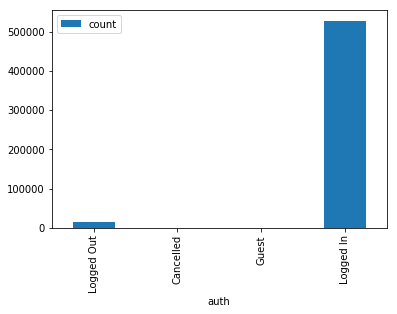

In [142]:
auth_df = df.select('ts', 'auth').groupBy('auth').count().toPandas()
auth_df.index = auth_df.auth
auth_df.plot.bar()

**I have defined cleanse_data and label_data functions in the beginning of this notebook**
**cleanse_data**:
This function first removes special characters from StringType columns. Only ',' and '-' is not removed because we see that location field as an example can be split using ','.
Couple of columns are generated based on ts, one is of timestamp type, the other one is datetype, which will be useful for aggregations and time based analysis.
userId is cast to longtype so that we can recognize empty strings and then rows with null user id's are removed.
The logging out records are of no use since they do not provide userid and other useful fields.It is not relevant to use for further analysis.
Finally location field is split with ',' and only state abbreviation is retained for further analysis, as it is easy to use and has less unique values considering it will be encoded for modelling.


In [143]:
df = cleanse_data(df)
df = label_data(df)
df = registered_days(df)

In [103]:
df.select('userId','location','label').distinct().groupby('location','label').count().show()

+--------+-----+-----+
|location|label|count|
+--------+-----+-----+
|      IN|    0|    8|
|      VA|    0|    4|
|      MD|    0|    2|
|      AZ|    0|    8|
|   RI-MA|    1|    2|
|   TN-VA|    1|    1|
|      TN|    1|    1|
|   MN-WI|    0|    7|
|      AZ|    1|    2|
|   VA-NC|    0|    3|
|      OK|    0|    1|
|   GA-AL|    1|    2|
|   RI-MA|    0|    3|
|      TX|    1|    5|
|      NJ|    1|    1|
|   MA-NH|    0|    6|
|      CT|    1|    2|
|      LA|    0|    3|
|      AL|    0|    7|
|      NC|    0|    8|
+--------+-----+-----+
only showing top 20 rows



In [104]:
df.select('userId','gender','label').distinct().groupby('gender','label').count().show()

+------+-----+-----+
|gender|label|count|
+------+-----+-----+
|     M|    1|   54|
|     F|    0|  153|
|     F|    1|   45|
|     M|    0|  196|
+------+-----+-----+



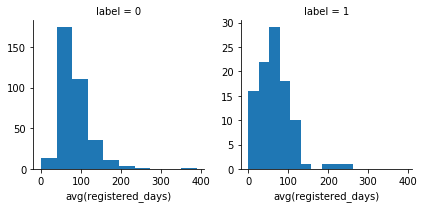

In [107]:
register_df = df.groupBy(['userId', 'label']).avg('registered_days').toPandas()

# compare two groups of users
g = sns.FacetGrid(register_df, col="label", sharey=False)
g.map(plt.hist, "avg(registered_days)");

**Long time Registered users seems to be more loyal.**

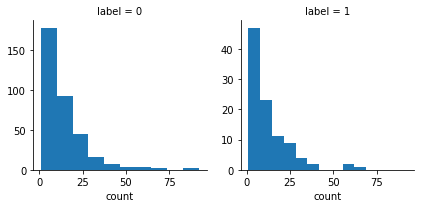

In [108]:
sess_df = df.select('userId', 'label', 'sessionId').distinct().groupBy(['userId', 'label']).count().toPandas()

# compare two groups of users
g = sns.FacetGrid(sess_df, col="label", sharey=False)
g.map(plt.hist, "count");

**Number of distinct sessions per user is less for churn users**

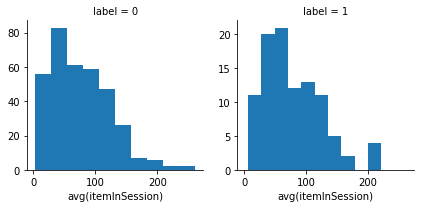

In [109]:
item_df = df.groupBy(['userId', 'label']).avg('itemInSession').toPandas()

# compare two groups of users
g = sns.FacetGrid(item_df, col="label", sharey=False)
g.map(plt.hist, "avg(itemInSession)");

**Average number of items per user is less for churn users**

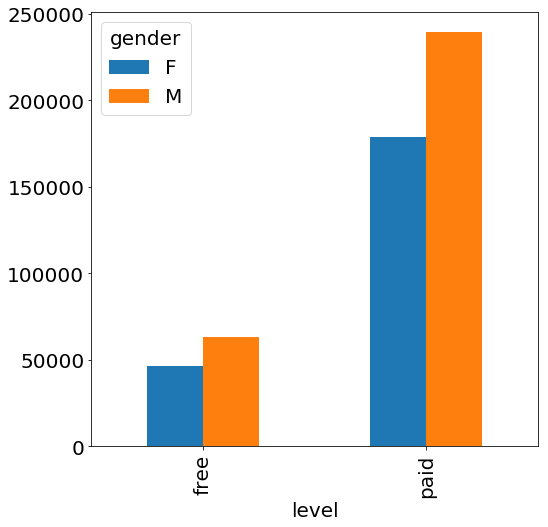

In [115]:
df_count = df.select('userId','gender','level').groupby('gender','level').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
df_count.pivot(index='level', columns='gender', values='count').plot(kind='bar', ax=ax)
# plt.savefig('gender_level.png')

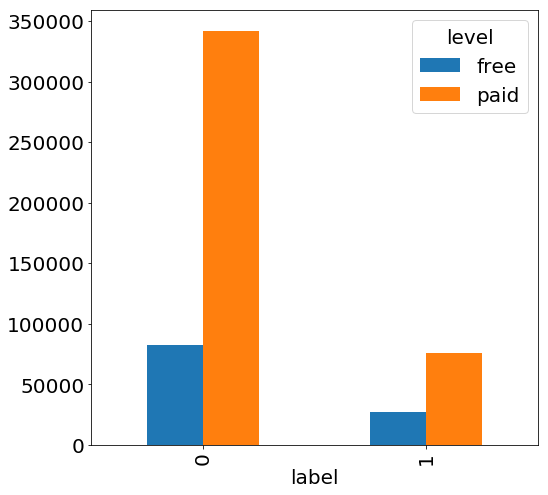

In [116]:
df_count_ = df.select('userId','level','label').groupby('level','label').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
df_count_.pivot(index='label', columns='level', values='count').plot(kind='bar', ax=ax)
# plt.savefig('label_level.png')

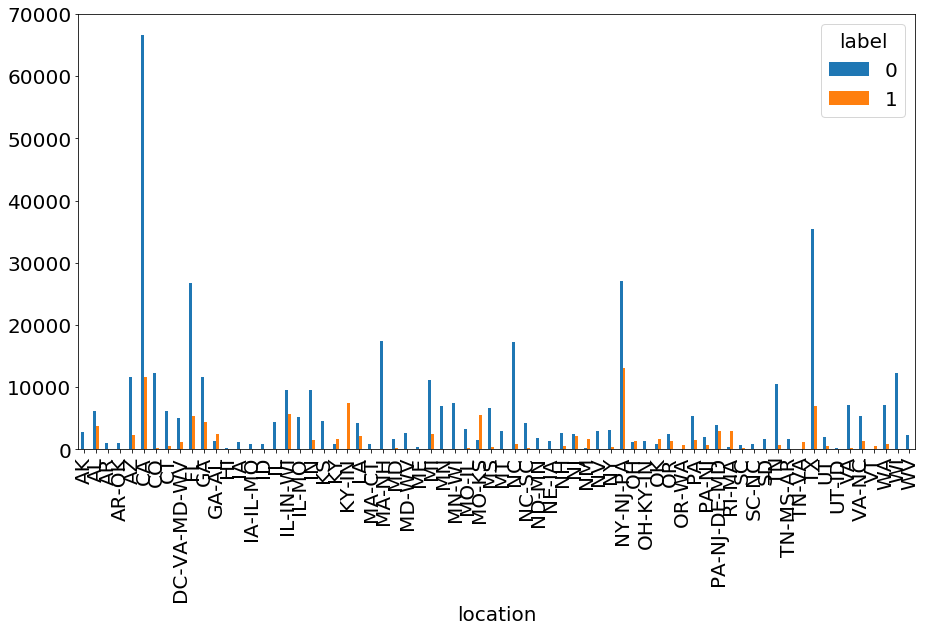

In [114]:
df_state_count_ = df.select('userId','location','label').groupby('location','label').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
df_state_count_.pivot(index='location', columns='label', values='count').plot(kind='bar', ax=ax)
# plt.savefig('state_churn.png')



**From the plot one can say that location is also an important factor for churn** Some states has large proportion of churners whereas some have none.